## Домашнее задание

#### 1. В коде из методички реализуйте один или несколько критериев останова (количество листьев, количество используемых признаков, глубина дерева и т.д.).

Сгенерируем данные

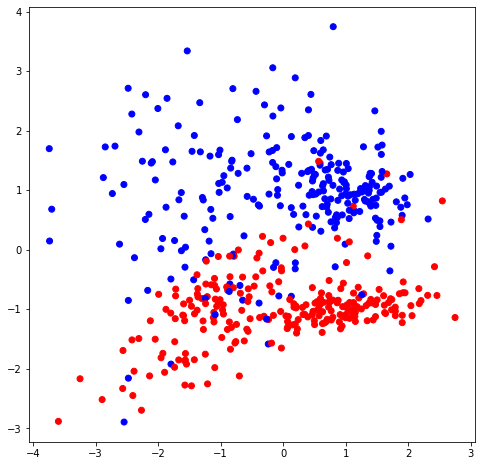

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# Сгенерируем данные
from sklearn import datasets
from matplotlib.colors import ListedColormap

# сгеренируем данные с помощью sklearn.datasets
classes = datasets.make_classification(n_samples=500, n_features=2, n_informative=2,
                                       n_redundant=0, n_classes=2, random_state=6)
# datasets.make_blobs(centers = 5, cluster_std = 1, random_state=1)

# и изобразим их на графике
colors = ListedColormap(['red', 'blue'])
light_colors = ListedColormap(['lightcoral', 'lightblue'])

plt.figure(figsize=(8, 8))
plt.scatter([x[0] for x in classes[0]], [x[1] for x in classes[0]], c=classes[1], cmap=colors);

Далее разделим выборку на обучающую и тестовую.

In [3]:
# перемешивание датасета
np.random.seed(41)
shuffle_index = np.random.permutation(classes[0].shape[0])
X_shuffled, y_shuffled = classes[0][shuffle_index], classes[1][shuffle_index]

# разбивка на обучающую и тестовую выборки
train_proportion = 0.7
train_test_cut = int(len(classes[0]) * train_proportion)

train_data, test_data, train_labels, test_labels = \
    X_shuffled[:train_test_cut], \
    X_shuffled[train_test_cut:], \
    y_shuffled[:train_test_cut], \
    y_shuffled[train_test_cut:]

In [4]:
# Реализуем класс узла

class Node:
   
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле

In [5]:
# И класс терминального узла (листа)

class Leaf:
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = self.predict()
        
    def predict(self):
        # подсчет количества объектов разных классов
        classes = {}  # сформируем словарь "класс: количество объектов"
        for label in self.labels:
            if label not in classes:
                classes[label] = 0
            classes[label] += 1
        #  найдем класс, количество объектов которого будет максимальным в этом листе и вернем его    
        prediction = max(classes, key=classes.get)
        return prediction        

Индекс Джини:
$$H(X) = 1 - \sum^{K}_{k=1}p_{k}^{2}.$$

In [6]:
# Расчет критерия Джини

def gini(labels):
    #  подсчет количества объектов разных классов
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1

    #  расчет критерия
    impurity = 1 # коэффициент неопределенности Джини
    for label in classes:
        p = classes[label] / len(labels)
        impurity -= p ** 2
        
    return impurity

Функционал качества:  

$$Q = H(X_{m}) - \frac{|X_{l}|}{|X_{m}|}H(X_{l}) - \frac{|X_{r}|}{|X_{m}|}H(X_{r})$$

In [7]:
# Расчет качества

def quality(left_labels, right_labels, current_gini):

    # доля выбоки, ушедшая в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    
    return current_gini - p * gini(left_labels) - (1 - p) * gini(right_labels)

In [8]:
# Разбиение датасета в узле

def split(data, labels, index, t):
    left = np.where(data[:, index] <= t)
    right = np.where(data[:, index] > t)
        
    true_data = data[left]
    false_data = data[right]
    true_labels = labels[left]
    false_labels = labels[right]
        
    return true_data, false_data, true_labels, false_labels

In [9]:
# Нахождение наилучшего разбиения

def find_best_split(data, labels):
    
    #  обозначим минимальное количество объектов в узле
    min_leaf = 5

    current_gini = gini(labels)

    best_quality = 0
    best_t = None
    best_index = None
    
    n_features = data.shape[1]
    
    for index in range(n_features):
        # будем проверять только уникальные значения признака, исключая повторения
        t_values = np.unique([row[index] for row in data])
        
        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
           
        #  пропускаем разбиения, в которых в узле остается менее 5 объектов    
            if len(true_data) < min_leaf or len(false_data) < min_leaf:
                continue
            
            current_quality = quality(true_labels, false_labels, current_gini)
            
            #  выбираем порог, на котором получается максимальный прирост качества
            if current_quality > best_quality:
                best_quality, best_t, best_index = current_quality, t, index

    return best_quality, best_t, best_index

In [10]:
def classify_object(obj, node):

    #  Останавливаем рекурсию, если достигли листа
    if isinstance(node, Leaf):
        answer = node.prediction
        return answer

    if obj[node.index] <= node.t:
        return classify_object(obj, node.true_branch)
    else:
        return classify_object(obj, node.false_branch)

In [11]:
def predict(data, tree):
    
    classes = []
    for obj in data:
        prediction = classify_object(obj, tree)
        classes.append(prediction)
    return classes

Органичим глубину дерева

In [13]:
d = int(input("Введите максимальную глубину дерева: "))

# Построение дерева с помощью рекурсивной функции
def build_tree(data, labels):
    global depth, true_branch, false_branch
    print("Глубина", depth)
    quality, t, index = find_best_split(data, labels)

#      Базовый случай - прекращаем рекурсию, когда нет прироста в качества
    if quality == 0:
        return Leaf(data, labels)
        print("quality == 0")
    
    if depth == d:
        return Leaf(data, labels)
    
    # Рекурсивно строим два поддерева
    print("Делаем ветвление на глубине ", depth)
    depth += 1
    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
    true_branch = build_tree(true_data, true_labels)
    false_branch = build_tree(false_data, false_labels)

    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, t, true_branch, false_branch)

Введите максимальную глубину дерева: 5


In [14]:
# Построим дерево по обучающей выборке
depth = 0
true_branch = None
false_branch = None
my_tree = build_tree(train_data, train_labels)

Глубина 0
Делаем ветвление на глубине  0
Глубина 1
Делаем ветвление на глубине  1
Глубина 2
Делаем ветвление на глубине  2
Глубина 3
Делаем ветвление на глубине  3
Глубина 4
Делаем ветвление на глубине  4
Глубина 5
Глубина 5
Глубина 5
Глубина 5
Глубина 5
Глубина 5


In [15]:
# Напечатаем ход нашего дерева
def print_tree(node, spacing=""):

    # Если лист, то выводим его прогноз
    if isinstance(node, Leaf):
        print(spacing + "Прогноз:", node.prediction)
        return

    # Выведем значение индекса и порога на этом узле
    print(spacing + 'Индекс', str(node.index))
    print(spacing + 'Порог', str(node.t))

    # Рекурсионный вызов функции на положительном поддереве
    print (spacing + '--> True:')
    print_tree(node.true_branch, spacing + "  ")

    # Рекурсионный вызов функции на отрицательном поддереве
    print (spacing + '--> False:')
    print_tree(node.false_branch, spacing + "  ")
    
print_tree(my_tree)

Индекс 1
Порог -0.107726691940364
--> True:
  Индекс 1
  Порог -0.3549877301133244
  --> True:
    Индекс 0
    Порог -0.23882214445115557
    --> True:
      Индекс 0
      Порог -0.4381064214473833
      --> True:
        Индекс 0
        Порог -1.793845443769914
        --> True:
          Прогноз: 0
        --> False:
          Прогноз: 0
      --> False:
        Прогноз: 1
    --> False:
      Прогноз: 0
  --> False:
    Прогноз: 0
--> False:
  Прогноз: 1


In [16]:
# Получим ответы для обучающей выборки 
train_answers = predict(train_data, my_tree)

# Получим ответы для тестовой выборки 
test_answers = predict(test_data, my_tree)

In [17]:
# Введем функцию подсчета точности как доли правильных ответов
def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0

In [18]:
# Точность на обучающей выборке
train_accuracy = accuracy_metric(train_labels, train_answers)
train_accuracy

91.71428571428571

In [19]:
# Точность на тестовой выборке
test_accuracy = accuracy_metric(test_labels, test_answers)
test_accuracy

89.33333333333333

Text(0.5, 1.0, 'Test accuracy=89.33')

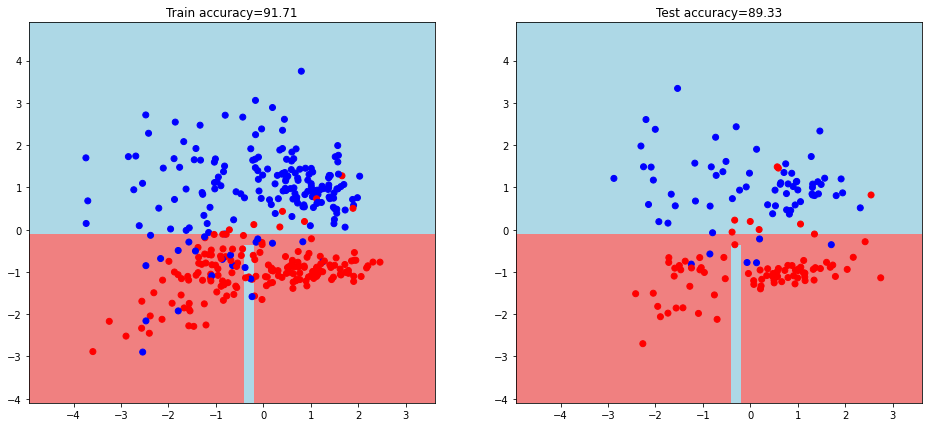

In [20]:
# Визуализируем дерево на графике

def get_meshgrid(data, step=.05, border=1.2):
    x_min, x_max = data[:, 0].min() - border, data[:, 0].max() + border
    y_min, y_max = data[:, 1].min() - border, data[:, 1].max() + border
    return np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))

plt.figure(figsize = (16, 7))

# график обучающей выборки
plt.subplot(1,2,1)
xx, yy = get_meshgrid(train_data)
mesh_predictions = np.array(predict(np.c_[xx.ravel(), yy.ravel()], my_tree)).reshape(xx.shape)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
plt.title(f'Train accuracy={train_accuracy:.2f}')

# график тестовой выборки
plt.subplot(1,2,2)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
plt.title(f'Test accuracy={test_accuracy:.2f}')

#### 2. Для задачи классификации обучите дерево решений с использованием критериев разбиения Джини и Энтропия. Сравните качество классификации, сделайте выводы.

In [21]:
# Расчет критерия энтропия

def entropy(labels):
    #  подсчет количества объектов разных классов
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1

    #  расчет критерия
    impurity = 1 # коэффициент неопределенности энтропии
    for label in classes:
        p = classes[label] / len(labels)
        impurity -= np.sum(p * np.log2(p))   
        
    return impurity

Функционал качества:  

$$Q = H(X_{m}) - \frac{|X_{l}|}{|X_{m}|}H(X_{l}) - \frac{|X_{r}|}{|X_{m}|}H(X_{r})$$

In [22]:
# Расчет качества

def quality(left_labels, right_labels, current_entropy):

    # доля выбоки, ушедшая в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    
    return current_entropy - p * entropy(left_labels) - (1 - p) * entropy(right_labels)

In [23]:
# Разбиение датасета в узле

def split(data, labels, index, t):
    left = np.where(data[:, index] <= t)
    right = np.where(data[:, index] > t)
        
    true_data = data[left]
    false_data = data[right]
    true_labels = labels[left]
    false_labels = labels[right]
        
    return true_data, false_data, true_labels, false_labels

In [24]:
# Нахождение наилучшего разбиения

def find_best_split(data, labels):
    
    #  обозначим минимальное количество объектов в узле
    min_leaf = 5

    current_entropy = entropy(labels)

    best_quality = 0
    best_t = None
    best_index = None
    
    n_features = data.shape[1]
    
    for index in range(n_features):
        # будем проверять только уникальные значения признака, исключая повторения
        t_values = np.unique([row[index] for row in data])
        
        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
           
        #  пропускаем разбиения, в которых в узле остается менее 5 объектов    
            if len(true_data) < min_leaf or len(false_data) < min_leaf:
                continue
            
            current_quality = quality(true_labels, false_labels, current_entropy)
            
            #  выбираем порог, на котором получается максимальный прирост качества
            if current_quality > best_quality:
                best_quality, best_t, best_index = current_quality, t, index

    return best_quality, best_t, best_index

In [25]:
def classify_object(obj, node):

    #  Останавливаем рекурсию, если достигли листа
    if isinstance(node, Leaf):
        answer = node.prediction
        return answer

    if obj[node.index] <= node.t:
        return classify_object(obj, node.true_branch)
    else:
        return classify_object(obj, node.false_branch)

In [26]:
def predict(data, tree):
    
    classes = []
    for obj in data:
        prediction = classify_object(obj, tree)
        classes.append(prediction)
    return classes

Органичим глубину дерева

In [27]:
d = int(input("Введите максимальную глубину дерева: "))

# Построение дерева с помощью рекурсивной функции
def build_tree(data, labels):
    global depth, true_branch, false_branch
    print("Глубина", depth)
    quality, t, index = find_best_split(data, labels)

#      Базовый случай - прекращаем рекурсию, когда нет прироста в качества
    if quality == 0:
        return Leaf(data, labels)
        print("quality == 0")
    
    if depth == d:
        return Leaf(data, labels)
    
    # Рекурсивно строим два поддерева
    print("Делаем ветвление на глубине ", depth)
    depth += 1
    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
    true_branch = build_tree(true_data, true_labels)
    false_branch = build_tree(false_data, false_labels)

    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, t, true_branch, false_branch)

Введите максимальную глубину дерева: 5


In [28]:
# Построим дерево по обучающей выборке
depth = 0
true_branch = None
false_branch = None
my_tree = build_tree(train_data, train_labels)

Глубина 0
Делаем ветвление на глубине  0
Глубина 1
Делаем ветвление на глубине  1
Глубина 2
Делаем ветвление на глубине  2
Глубина 3
Делаем ветвление на глубине  3
Глубина 4
Делаем ветвление на глубине  4
Глубина 5
Глубина 5
Глубина 5
Глубина 5
Глубина 5
Глубина 5


In [29]:
# Напечатаем ход нашего дерева
def print_tree(node, spacing=""):

    # Если лист, то выводим его прогноз
    if isinstance(node, Leaf):
        print(spacing + "Прогноз:", node.prediction)
        return

    # Выведем значение индекса и порога на этом узле
    print(spacing + 'Индекс', str(node.index))
    print(spacing + 'Порог', str(node.t))

    # Рекурсионный вызов функции на положительном поддереве
    print (spacing + '--> True:')
    print_tree(node.true_branch, spacing + "  ")

    # Рекурсионный вызов функции на отрицательном поддереве
    print (spacing + '--> False:')
    print_tree(node.false_branch, spacing + "  ")
    
print_tree(my_tree)

Индекс 1
Порог -0.107726691940364
--> True:
  Индекс 1
  Порог -0.5175343065438042
  --> True:
    Индекс 0
    Порог -0.23882214445115557
    --> True:
      Индекс 0
      Порог -0.46469463939970623
      --> True:
        Индекс 0
        Порог -2.165676399540467
        --> True:
          Прогноз: 0
        --> False:
          Прогноз: 0
      --> False:
        Прогноз: 1
    --> False:
      Прогноз: 0
  --> False:
    Прогноз: 0
--> False:
  Прогноз: 1


In [30]:
# Получим ответы для обучающей выборки 
train_answers = predict(train_data, my_tree)

# Получим ответы для тестовой выборки 
test_answers = predict(test_data, my_tree)

In [31]:
# Введем функцию подсчета точности как доли правильных ответов
def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0

In [32]:
# Точность на обучающей выборке
train_accuracy = accuracy_metric(train_labels, train_answers)
train_accuracy

91.71428571428571

In [33]:
# Точность на тестовой выборке
test_accuracy = accuracy_metric(test_labels, test_answers)
test_accuracy

90.0

Text(0.5, 1.0, 'Test accuracy=90.00')

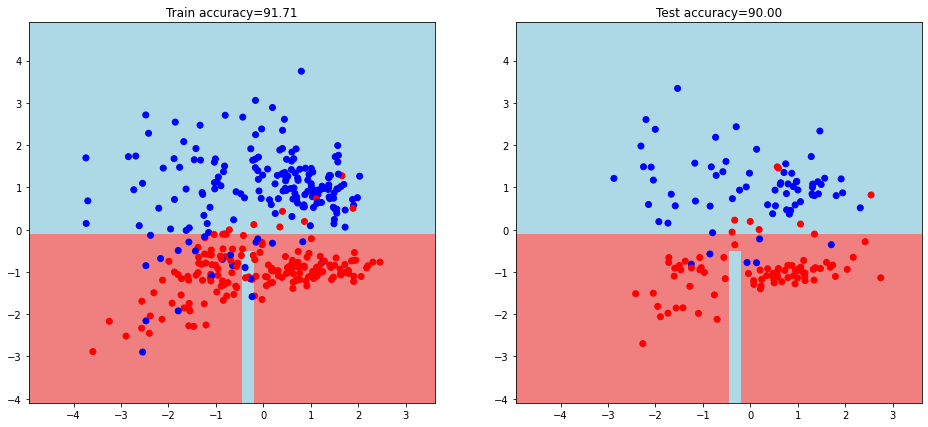

In [34]:
# Визуализируем дерево на графике

def get_meshgrid(data, step=.05, border=1.2):
    x_min, x_max = data[:, 0].min() - border, data[:, 0].max() + border
    y_min, y_max = data[:, 1].min() - border, data[:, 1].max() + border
    return np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))

plt.figure(figsize = (16, 7))

# график обучающей выборки
plt.subplot(1,2,1)
xx, yy = get_meshgrid(train_data)
mesh_predictions = np.array(predict(np.c_[xx.ravel(), yy.ravel()], my_tree)).reshape(xx.shape)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
plt.title(f'Train accuracy={train_accuracy:.2f}')

# график тестовой выборки
plt.subplot(1,2,2)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
plt.title(f'Test accuracy={test_accuracy:.2f}')

##### Вывод: Видим, что качество работы моделей на этих данных идентичное

#### 3. *Реализуйте дерево для задачи регрессии. Возьмите за основу дерево, реализованное в методичке, заменив механизм предсказания в листе на взятие среднего значения по выборке, а критерий Джини на дисперсию значений.

Сгенерируем датасет для регрессии

In [35]:
from sklearn.datasets import load_boston
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import learning_curve 
from sklearn.metrics import make_scorer 
%matplotlib inline

np.random.seed(42)

boston_data = load_boston() 
boston_df = pd.DataFrame(boston_data.data, columns=boston_data.feature_names)
boston_df_2 = pd.DataFrame(boston_data.data, columns=boston_data.feature_names)
# boston_df = np.array(boston_df[['RM', 'LSTAT']])

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [36]:
boston_df

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33
...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.06263,0.0,11.93,0.0,0.573,6.593,69.1,2.4786,1.0,273.0,21.0,391.99,9.67
502,0.04527,0.0,11.93,0.0,0.573,6.120,76.7,2.2875,1.0,273.0,21.0,396.90,9.08
503,0.06076,0.0,11.93,0.0,0.573,6.976,91.0,2.1675,1.0,273.0,21.0,396.90,5.64
504,0.10959,0.0,11.93,0.0,0.573,6.794,89.3,2.3889,1.0,273.0,21.0,393.45,6.48


Переведем таблицу в матрицу

In [37]:
boston_df = np.array(boston_df)
target = boston_data.target

In [38]:
# И класс терминального узла (листа)

class Leaf:
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = self.predict()
        
    def predict(self):
        prediction = np.mean(self.labels)
        return prediction        

In [39]:
#перемешаем данные
np.random.seed(41)
shuffle_index = np.random.permutation(boston_df.shape[0])
X_shuffled, y_shuffled = boston_df[shuffle_index], np.array(target[shuffle_index])


In [40]:
# разбивка на обучающую и тестовую выборки
train_proportion = 0.7
train_test_cut = int(len(classes[0]) * train_proportion)

train_data, test_data, train_labels, test_labels = \
    X_shuffled[:train_test_cut], \
    X_shuffled[train_test_cut:], \
    y_shuffled[:train_test_cut], \
    y_shuffled[train_test_cut:]

В случае регрессии разброс будет характеризоваться дисперсией, поэтому критерий информативности будет записан в виде
 
$$H(X) = \frac{1}{X}\sum_{i\in X}(y_{i} - \bar{y}(X))^{2},$$
 
где $\bar{y}(X)$ - среднее значение ответа в выборке $X$:
 
$$\bar{y}(X) = \frac{1}{|X|}\sum_{i\in X}y_{i}.$$

In [41]:
# Расчет дисперсии
def variance(labels):

    impurity = (np.sum())/labels
    return impurity

In [42]:
# Расчет дисперсии

def variance(labels):

    impurity = np.var(labels) 
    return impurity

In [43]:
# Расчет качества

def quality(left_labels, right_labels, current_variance):

    # доля выбоки, ушедшая в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    
    return current_variance - p * variance(left_labels) - (1 - p) * variance(right_labels)

In [44]:
# Разбиение датасета в узле

def split(data, labels, index, t):
    left = np.where(data[:, index] <= t)
    right = np.where(data[:, index] > t)
        
    true_data = data[left]
    false_data = data[right]
    true_labels = labels[left]
    false_labels = labels[right]
        
    return true_data, false_data, true_labels, false_labels

In [45]:
# Нахождение наилучшего разбиения

def find_best_split(data, labels):
    
    #  обозначим минимальное количество объектов в узле
    min_leaf = 5

    current_variance = variance(labels)

    best_quality = 0
    best_t = None
    best_index = None
    
    n_features = data.shape[1]
    
    for index in range(n_features):
        # будем проверять только уникальные значения признака, исключая повторения
        t_values = np.unique([row[index] for row in data])
        
        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
           
        #  пропускаем разбиения, в которых в узле остается менее 5 объектов    
            if len(true_data) < min_leaf or len(false_data) < min_leaf:
                continue
            
            current_quality = quality(true_labels, false_labels, current_variance)
            
            #  выбираем порог, на котором получается максимальный прирост качества
            if current_quality > best_quality:
                best_quality, best_t, best_index = current_quality, t, index

    return best_quality, best_t, best_index

In [46]:
def classify_object(obj, node):

    #  Останавливаем рекурсию, если достигли листа
    if isinstance(node, Leaf):
        answer = node.prediction
        return answer

    if obj[node.index] <= node.t:
        return classify_object(obj, node.true_branch)
    else:
        return classify_object(obj, node.false_branch)

In [47]:
def predict(data, tree):
    
    classes = []
    for obj in data:
        prediction = classify_object(obj, tree)
        classes.append(prediction)
    return classes

Органичим глубину дерева

In [48]:
d = int(input("Введите максимальную глубину дерева: "))

# Построение дерева с помощью рекурсивной функции
def build_tree(data, labels):
    global depth, true_branch, false_branch
    print("Глубина", depth)
    quality, t, index = find_best_split(data, labels)

#      Базовый случай - прекращаем рекурсию, когда нет прироста в качества
    if quality == 0:
        return Leaf(data, labels)
        print("quality == 0")
    
    if depth == d:
        return Leaf(data, labels)
    
    # Рекурсивно строим два поддерева
    print("Делаем ветвление на глубине ", depth)
    depth += 1
    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
    true_branch = build_tree(true_data, true_labels)
    false_branch = build_tree(false_data, false_labels)

    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, t, true_branch, false_branch)

Введите максимальную глубину дерева: 5


In [49]:
# Построим дерево по обучающей выборке
depth = 0
true_branch = None
false_branch = None
my_tree = build_tree(train_data, train_labels)

Глубина 0
Делаем ветвление на глубине  0
Глубина 1
Делаем ветвление на глубине  1
Глубина 2
Делаем ветвление на глубине  2
Глубина 3
Глубина 3
Делаем ветвление на глубине  3
Глубина 4
Делаем ветвление на глубине  4
Глубина 5
Глубина 5
Глубина 5
Глубина 5
Глубина 5


In [50]:
# Напечатаем ход нашего дерева
def print_tree(node, spacing=""):

    # Если лист, то выводим его прогноз
    if isinstance(node, Leaf):
        print(spacing + "Прогноз:", node.prediction)
        return

    # Выведем значение индекса и порога на этом узле
    print(spacing + 'Индекс', str(node.index))
    print(spacing + 'Порог', str(node.t))

    # Рекурсионный вызов функции на положительном поддереве
    print (spacing + '--> True:')
    print_tree(node.true_branch, spacing + "  ")

    # Рекурсионный вызов функции на отрицательном поддереве
    print (spacing + '--> False:')
    print_tree(node.false_branch, spacing + "  ")
    
print_tree(my_tree)

Индекс 12
Порог 9.53
--> True:
  Индекс 5
  Порог 7.42
  --> True:
    Индекс 7
    Порог 1.7573
    --> True:
      Индекс 5
      Порог 6.538
      --> True:
        Прогноз: 22.87068965517241
      --> False:
        Прогноз: 27.54
    --> False:
      Индекс 5
      Порог 6.794
      --> True:
        Индекс 5
        Порог 6.538
        --> True:
          Прогноз: 22.87068965517241
        --> False:
          Прогноз: 27.54
      --> False:
        Прогноз: 32.768571428571434
  --> False:
    Прогноз: 44.915
--> False:
  Прогноз: 17.74455445544554


In [51]:
# Получим ответы для обучающей выборки 
train_answers = predict(train_data, my_tree)

# Получим ответы для тестовой выборки 
test_answers = predict(test_data, my_tree)

In [52]:
from sklearn.metrics import mean_absolute_error

In [53]:
# Точность на обучающей выборке
mean_absolute_error(train_labels, train_answers)

3.6628201238843094

In [54]:
# Точность на тестовой выборке
mean_absolute_error(test_labels, test_answers)

3.911579368622728